In [1]:
from datetime import datetime
import torch
import requests
import cv2
from PIL import Image, ImageOps
from io import BytesIO
from diffusers import StableDiffusionImg2ImgPipeline, ControlNetModel, StableDiffusionControlNetPipeline
from diffusers.utils import load_image
from controlnet_aux import OpenposeDetector, HEDdetector
import logging
from transformers import pipeline
import numpy as np

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
hed = HEDdetector.from_pretrained('lllyasviel/ControlNet')
# cnmodel = "lllyasviel/sd-controlnet-openpose"
# controlnet = ControlNetModel.from_pretrained(
#     cnmodel,
#     torch_dtype=torch.float16,
#     use_auth_token=TOKEN,
# )
ctrlnet1_id = "lllyasviel/sd-controlnet-canny"
ctrlnet2_id = "lllyasviel/sd-controlnet-canny"
ctrlnet3_id = "lllyasviel/sd-controlnet-openpose"
controlnet = [
    ControlNetModel.from_pretrained(ctrlnet1_id, torch_dtype=torch.float16),
    ControlNetModel.from_pretrained(ctrlnet2_id, torch_dtype=torch.float16),
    ControlNetModel.from_pretrained(ctrlnet3_id, torch_dtype=torch.float16),
]

device = "cuda"
pipeline_id = "Auryg/Lyriel_1.5_Diffusers"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    pipeline_id,
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16,
    # custom_pipeline="lpw_stable_diffusion",
    # use_auth_token=TOKEN,
).to(device)

c:\Users\Genich\huggingface\.myvenv\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Genich\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

In [2]:
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
log_name = r'./log/ctrl3.log'
logging.basicConfig(filename=log_name)
rh = logging.handlers.RotatingFileHandler(
    log_name, 
    encoding='utf-8',
    maxBytes=10000,
    backupCount=100
)

if not log.hasHandlers():
    log.addHandler(rh)


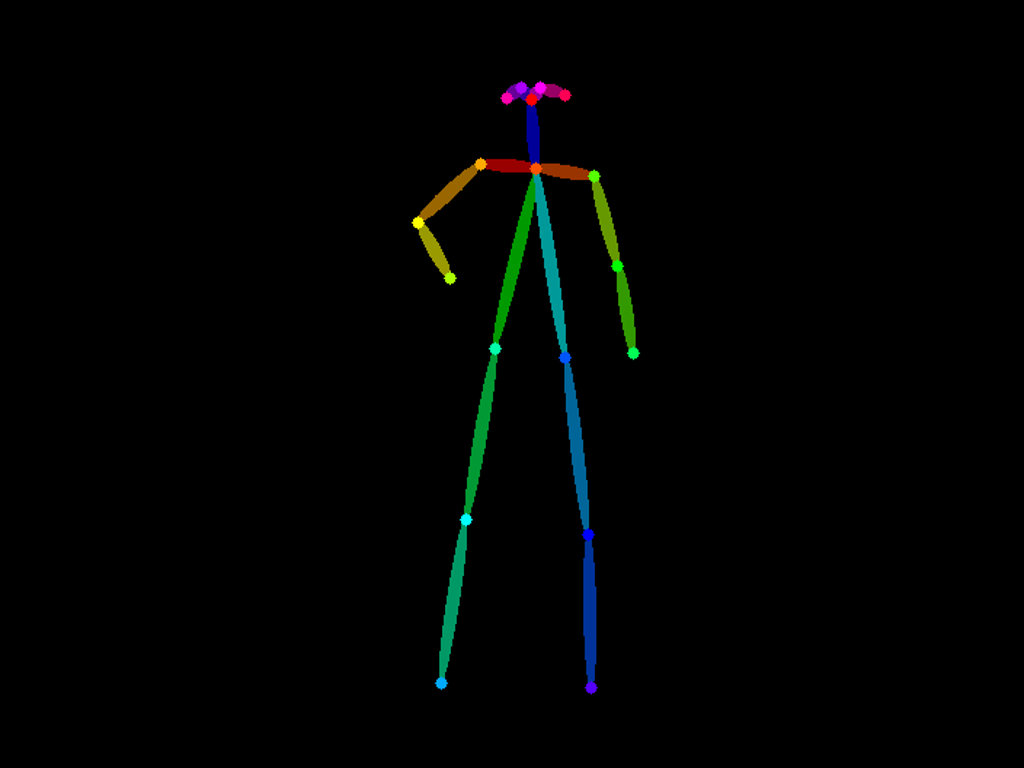

In [3]:
file_path_pose = "pic/pose3_1024.png"
init_image = Image.open(file_path_pose).convert("RGB")
openpose_image = openpose(init_image)
px = (1024,768)
openpose_image = openpose_image.resize(px)
openpose_image

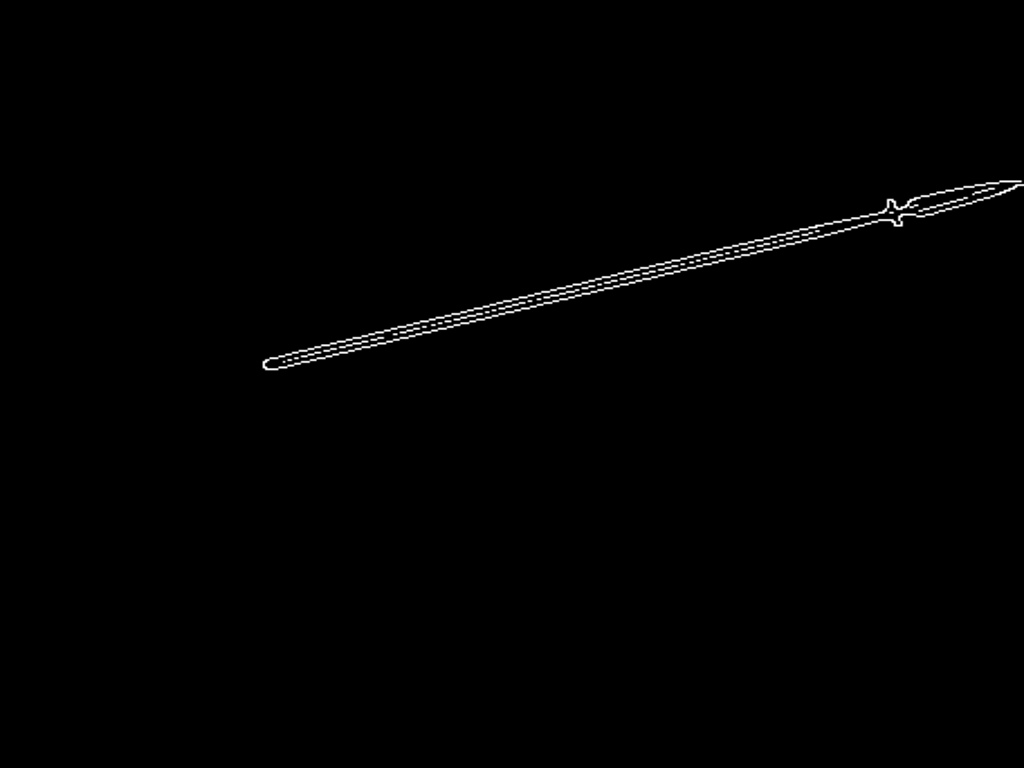

In [4]:
file_path_weapon = "pic/pose3_spear.png"
weapon = Image.open(file_path_weapon).convert("RGB")
weapon = ImageOps.invert(weapon)
weapon = weapon.resize(px)
weapon
arr_w=np.array(load_image(file_path_weapon))
# head = head[:,:,None]
weapon = cv2.Canny(arr_w,150,200)[:,:,None]
weapon = np.concatenate([weapon]*3, axis=2)
weapon = Image.fromarray(weapon)
weapon = weapon.resize(px)
weapon

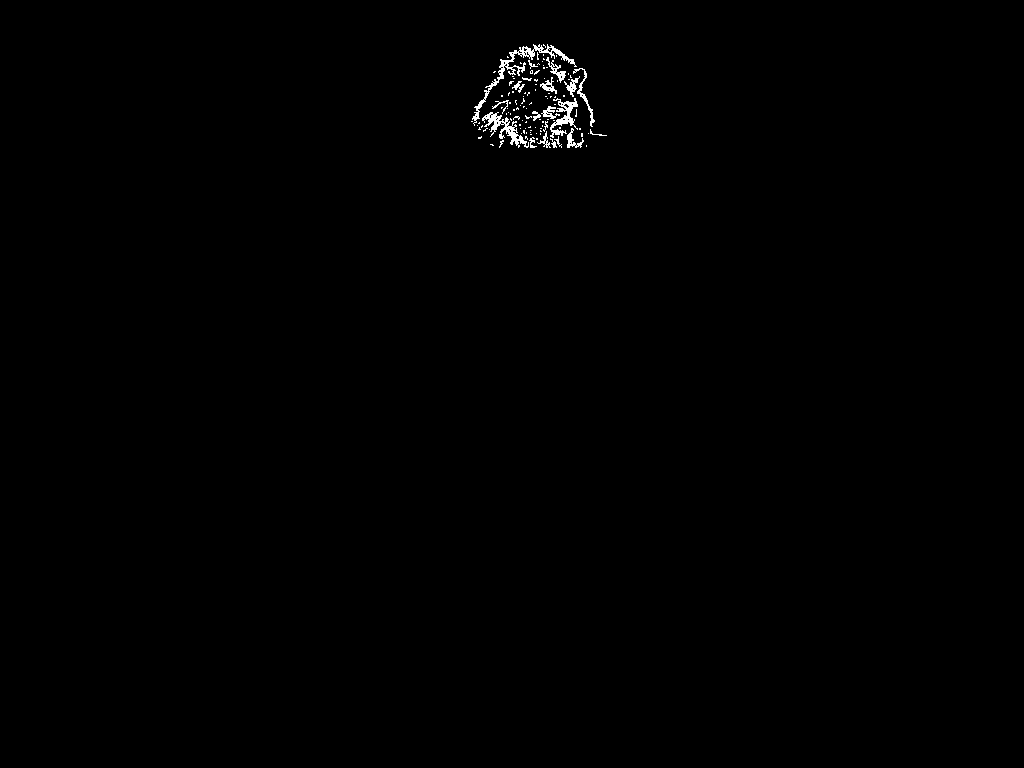

In [5]:
# depth_estimator = pipeline(task="depth-estimation")
file_path_face = "pic/pose3_lion.png"

# init_image_bg = Image.open(file_path).convert("RGB")
# init_image_bg = init_image_bg.resize(init_image.size)
head = Image.open(file_path_face).convert("RGB")
head = ImageOps.invert(head)
# arr = np.array(depth_estimator(load_image(file_path_face))['depth'])
# arr=np.array(load_image(file_path_face))
# head = cv2.Canny(arr,150,200)
# head = head[:,:,None]
# head = np.concatenate([head,head,head], axis=2)
# head = Image.fromarray(head)
# head
# head = Image.open(file_path_face).convert("RGB")
# head = ImageOps.invert(head)
head = head.resize(px)
head


  0%|          | 0/50 [00:00<?, ?it/s]

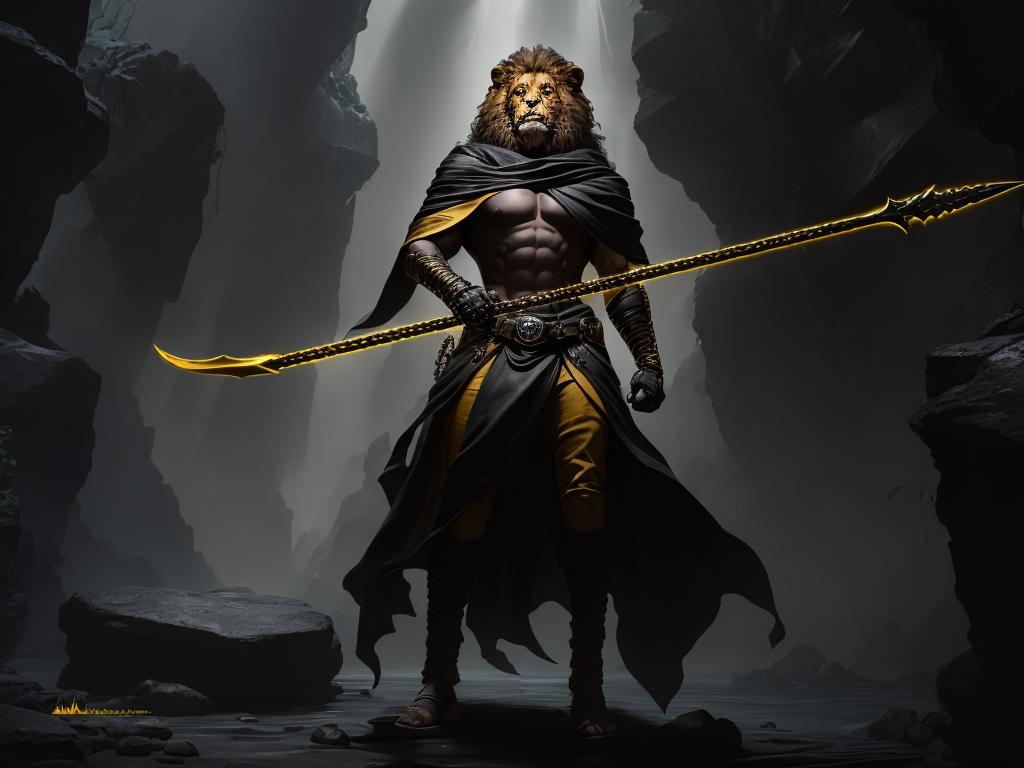

In [7]:
prompt = "(1male), (((lion-face man))), (((melanism))), gripping 1spear, looking at viewer, (((yellow eyes))), wearing ((((leather black robe)))), full body, (((rocky background))), Hand drawn, render, 8k, dark, big depth of field, Masterpiece, concept art, hyperrealistic, extremely detailed, dramatic, MtG"
negative_prompt = "logo, text, chinese, disfigured, kitsch, ugly, oversaturated, closeup, (deformed iris, deformed pupils, cgi, sketch, cartoon, anime:1.4), text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck"
generator = torch.Generator(device=device).manual_seed(1024)
ctrlnet_cond_scale = [0.95, 0.9, 0.7]
steps=50
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt, 
    image=[head, weapon, openpose_image], 
    controlnet_conditioning_scale=ctrlnet_cond_scale, 
    num_inference_steps=steps, 
    generator=generator,
    # max_embeddings_multiples=2,
).images[0]
now = datetime.now()
formatted_time = now.strftime("%Y%m%d%H%M%S")
image.save(f'pic/{formatted_time}.png')
log.info("***")
log.info(formatted_time)
log.info(f"PROMPT: {prompt}")
log.info(f"NEGATIVE PROMPT: {negative_prompt}")
log.info(f"MODEL: {pipeline_id}")
log.info(f"CONTROL NET 1: {ctrlnet1_id}")
log.info(f"CONTROL NET 2: {ctrlnet2_id}")
log.info(f"CONTROL NET 3: {ctrlnet3_id}")
log.info(f"IMAGE 1 PATH: {file_path_face}")
log.info(f"IMAGE 2 PATH: {file_path_weapon}")
log.info(f"IMAGE 3 PATH: {file_path_pose}")
log.info(f"CONTROLNET CONDITIONING SCALE: {ctrlnet_cond_scale}")
log.info(f"STEPS: {steps}")
image